In [1]:
from zipfile import ZipFile
file_name = 'concerete_crack_images.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

 

import os
import itertools
from glob import glob
import PIL
from PIL import Image
from scipy import ndimage 
import scipy
import sys

 

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

 

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
import scipy
from scipy import ndimage
import scipy.misc
import imageio
import numpy
import matplotlib as plt
from matplotlib.pyplot import imread

In [6]:
train_data_dir_positive = "concerete_crack_images/training/Positive/"
train_data_dir_negative = "concerete_crack_images/training/Negative/"

train_imgs_p = os.listdir(train_data_dir_positive)
train_imgs_n = os.listdir(train_data_dir_negative)
print(len(train_imgs_p))
print(len(train_imgs_n))

16070
16037


In [7]:
import imageio
import scipy.misc
num_px = 64

def extractFeaturesAndLabels(dir, impg_dataset, category):
  X = np.zeros((len(impg_dataset), num_px*num_px*3))
  y = np.zeros((len(impg_dataset)))
  for i in range(0,len(impg_dataset)) :
    #Read an image from a file as an array.
    #The different colour bands/channels are stored 
    #in the third dimension, such that a 
    #grey-image is MxN, an RGB-image MxNx3 
    image = np.array(imageio.imread(dir + impg_dataset[i])) 
    #image = np.array(imageio.imread(dir + impg_dataset[i])) 
    
    # Resize the image. Size of the output image (height, width)
    image = scipy.misc.imresize(image, size=(num_px, num_px))
    
    # Convert the matrix to a vector
    image = image.reshape((1, num_px*num_px*3)).T     

    # Note that RGB (Red, Green, Blue) are 8 bit each.
    # Hence, the range for each individual colour is 0-255 (as 2^8 = 256 possibilities).
    # By dividing by 255, Convert the 0-255 range to a 0.0-1.0 range where 0.0 means 0 (0x00) and 1.0 means 255 (0xFF).
    image = image/255.0
    
    image = image.reshape((num_px*num_px*3,1))
    for j in range(0,num_px*num_px*3) :
        X[i][j] = image[j][0]
        
    if category == 'positive':
        y[i] = 1
    else:
        y[i] = 0

  y = y.astype(int)
  
  return(X, y)

def get_accuracy(model, X, y):
  y_pred = model.predict(X)

  if sys.version_info < (3, 0):
      accuracy = ((np.sum(y == y_pred, axis=0)).astype('float') /
            X.shape[0])
  else:
      accuracy = np.sum(y == y_pred, axis=0) / X.shape[0]

  #print('Accuracy: %.2f%%' % (accuracy * 100))
  
  return(accuracy * 100)

In [8]:
!pip install Pillow

In [10]:
X_train_p, y_train_p = extractFeaturesAndLabels(train_data_dir_positive, train_imgs_p, 'positive')
X_train_n, y_train_n = extractFeaturesAndLabels(train_data_dir_negative, train_imgs_n, 'negative')
X_train_mixed = np.concatenate([X_train_p,X_train_n])
y_train_mixed = np.concatenate([y_train_p,y_train_n])

AttributeError: ignored

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_train_mixed, y_train_mixed, test_size=0.25, random_state=1)

NameError: ignored

In [1]:
import numpy as np
from scipy.special import expit
import sys


class NeuralNetMLP(object):
    """ Feedforward neural network / Multi-layer perceptron classifier.

    Parameters
    ------------
    n_output : int
        Number of output units, should be equal to the
        number of unique class labels.
    n_features : int
        Number of features (dimensions) in the target dataset.
        Should be equal to the number of columns in the X array.
    n_hidden : int (default: 30)
        Number of hidden units.
    l1 : float (default: 0.0)
        Lambda value for L1-regularization.
        No regularization if l1=0.0 (default)
    l2 : float (default: 0.0)
        Lambda value for L2-regularization.
        No regularization if l2=0.0 (default)
    epochs : int (default: 500)
        Number of passes over the training set.
    eta : float (default: 0.001)
        Learning rate.
    alpha : float (default: 0.0)
        Momentum constant. Factor multiplied with the
        gradient of the previous epoch t-1 to improve
        learning speed
        w(t) := w(t) - (grad(t) + alpha*grad(t-1))
    decrease_const : float (default: 0.0)
        Decrease constant. Shrinks the learning rate
        after each epoch via eta / (1 + epoch*decrease_const)
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent circles.
    minibatches : int (default: 1)
        Divides training data into k minibatches for efficiency.
        Normal gradient descent learning if k=1 (default).
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    Attributes
    -----------
    cost_ : list
      Sum of squared errors after each epoch.

    """
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        """Encode labels into one-hot representation

        Parameters
        ------------
        y : array, shape = [n_samples]
            Target values.

        Returns
        -----------
        onehot : array, shape = (n_labels, n_samples)

        """
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        """Compute logistic function (sigmoid)

        Uses scipy.special.expit to avoid overflow
        error for very small input values z.

        """
        # return 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        """Compute gradient of the logistic function"""
        sg = self._sigmoid(z)
        return sg * (1.0 - sg)

    def _add_bias_unit(self, X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new

    def _feedforward(self, X, w1, w2):
        """Compute feedforward step

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ----------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        z3 : array, shape = [n_output_units, n_samples]
            Net input of output layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.

        """
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    def _L2_reg(self, lambda_, w1, w2):
        """Compute L2-regularization cost"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Compute L1-regularization cost"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    def _get_cost(self, y_enc, output, w1, w2):
        """Compute cost function.

        Parameters
        ----------
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        output : array, shape = [n_output_units, n_samples]
            Activation of the output layer (feedforward)
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        cost : float
            Regularized cost.

        """
        term1 = -y_enc * (np.log(output))
        term2 = (1.0 - y_enc) * np.log(1.0 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        """ Compute gradient step using backpropagation.

        Parameters
        ------------
        a1 : array, shape = [n_samples, n_features+1]
            Input values with bias unit.
        a2 : array, shape = [n_hidden+1, n_samples]
            Activation of hidden layer.
        a3 : array, shape = [n_output_units, n_samples]
            Activation of output layer.
        z2 : array, shape = [n_hidden, n_samples]
            Net input of hidden layer.
        y_enc : array, shape = (n_labels, n_samples)
            one-hot encoded class labels.
        w1 : array, shape = [n_hidden_units, n_features]
            Weight matrix for input layer -> hidden layer.
        w2 : array, shape = [n_output_units, n_hidden_units]
            Weight matrix for hidden layer -> output layer.

        Returns
        ---------
        grad1 : array, shape = [n_hidden_units, n_features]
            Gradient of the weight matrix w1.
        grad2 : array, shape = [n_output_units, n_hidden_units]
            Gradient of the weight matrix w2.

        """
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # regularize
        grad1[:, 1:] += self.l2 * w1[:, 1:]
        grad1[:, 1:] += self.l1 * np.sign(w1[:, 1:])
        grad2[:, 1:] += self.l2 * w2[:, 1:]
        grad2[:, 1:] += self.l1 * np.sign(w2[:, 1:])

        return grad1, grad2

    def predict(self, X):
        """Predict class labels

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.

        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.

        """
        if len(X.shape) != 2:
            raise AttributeError('X must be a [n_samples, n_features] array.\n'
                                 'Use X[:,None] for 1-feature classification,'
                                 '\nor X[[i]] for 1-sample classification')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data.

        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        y : array, shape = [n_samples]
            Target class labels.
        print_progress : bool (default: False)
            Prints progress as the number of epochs
            to stderr.

        Returns:
        ----------
        self

        """
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        for i in range(self.epochs):

            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:

                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)

                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2

        return self

# NeuralNet MLP 

In [ ]:
nn = NeuralNetMLP(n_output=2, 
                  n_features=x_train.shape[1], 
                  n_hidden=10,
                  l2=0.1, 
                  l1=0.1, 
                  epochs=50, 
                  eta=0.0001,
                  alpha=0.1, 
                  decrease_const=0.00001,
                  minibatches=100, 
                  shuffle=True,
                  random_state=1)

nn.fit(x_train, y_train, print_progress=True)

batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 6000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

training_accuracy=get_accuracy(nn, x_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_accuracy(nn, x_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)

import matplotlib.pyplot as plt

batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 6000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

training_accuracy=get_accuracy(nn, x_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_accuracy(nn, x_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)


Epoch: 100/100

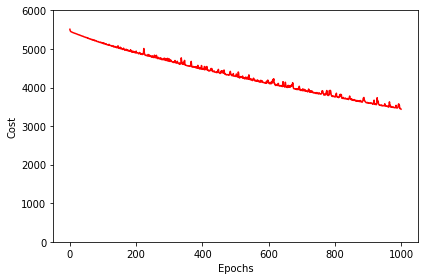

Training accuracy: 92.98%
Test accuracy: 91.93%


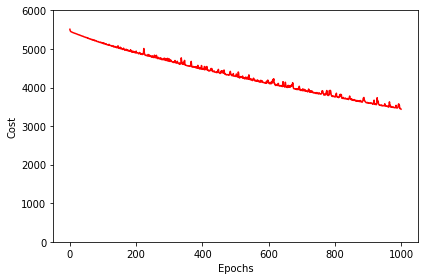

Training accuracy: 92.98%
Test accuracy: 91.93%


In [ ]:
nn1 = NeuralNetMLP(n_output=2, 
                  n_features=x_train.shape[1], 
                  n_hidden=10,
                  l2=0.1, 
                  l1=0.1, 
                  epochs=100, 
                  eta=0.0001,
                  alpha=0.1, 
                  decrease_const=0.00001,
                  minibatches=100, 
                  shuffle=True,
                  random_state=1)

nn1.fit(x_train, y_train, print_progress=True)

batches = np.array_split(range(len(nn1.cost_)), 1000)
cost_ary = np.array(nn1.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 6000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

training_accuracy=get_accuracy(nn1, x_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_accuracy(nn1, x_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)

import matplotlib.pyplot as plt

batches = np.array_split(range(len(nn1.cost_)), 1000)
cost_ary = np.array(nn1.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 6000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
#plt.savefig('./figures/cost2.png', dpi=300)
plt.show()

training_accuracy=get_accuracy(nn1, x_train, y_train)
print('Training accuracy: %.2f%%' %training_accuracy)

test_accuracy=get_accuracy(nn1, x_test, y_test)
print('Test accuracy: %.2f%%' %test_accuracy)


### Misclassified Sample

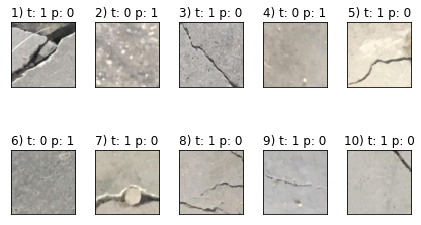

In [ ]:
y_test_pred = nn1.predict(x_test)

miscl_img = x_test[y_test != y_test_pred][:10]
correct_lab = y_test[y_test != y_test_pred][:10]
miscl_lab= y_test_pred[y_test != y_test_pred][:10]

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = miscl_img[i].reshape(num_px, num_px, 3)
    ax[i].imshow(img)
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import binarize, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def encoder(dataset, catFeatures, qtyFeatures):
  dataset = dataset[catFeatures + qtyFeatures]
  dataset_encoded = pd.get_dummies(dataset, 
                                   columns = catFeatures, 
                                   drop_first = True)
  
  return(dataset_encoded)

def plot_auc_curve(model, X, y):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  
  auc = roc_auc_score(y, y_pred_prob)
  fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
  
  plt.plot(fpr, tpr)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.title('ROC Curve\n AUC={auc}'.format(auc = auc))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.grid(True)

def model_training(model, X, y):
  model.fit(X,y)
  
  return(model)

def print_accuracy_metrics(model, X, y, threshold):
  try:
      y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
  y_pred_class = binarize([y_pred_prob], threshold)[0]
  
  print("Accurcay:", accuracy_score(y, y_pred_class))
  print("AUC:", roc_auc_score(y, y_pred_prob))
  print("Log Loss:", log_loss(y, y_pred_prob))
  print("Confusion Matrix:\n", confusion_matrix(y, y_pred_class))
  print("Recall:", recall_score(y, y_pred_class))
  print("Precision:", precision_score(y, y_pred_class))


def Find_Optimal_Cutoff(model, X, y):
  try:
    y_pred_prob = model.predict_proba(X)[:,1]
  except:
    d = model.decision_function(X)
    y_pred_prob = np.exp(d) / (1 + np.exp(d))
    
  fpr, tpr, threshold = roc_curve(y, y_pred_prob)
  i = np.arange(len(tpr)) 
  roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
  roc_t = roc.loc[(roc.tf-0).abs().argsort()[:1]]
  
  print("Optimal Cutoff:", roc_t['threshold'].values)
  return(roc_t['threshold'].values)
  
def feature_importance(model, X):
  importances = model.feature_importances_
  std = np.std([tree.feature_importances_ for tree in model.estimators_],
               axis=0)
  indices = np.argsort(importances)[::-1]

  # Print the feature ranking
  print("Feature ranking:")

  for f in range(X.shape[1]):
      print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

  # Plot the feature importances of the forest
  plt.figure()
  plt.title("Feature importances")
  plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
  plt.xticks(range(X.shape[1]), indices)
  plt.xlim([-1, X.shape[1]])
  plt.show()

# Plot calibration plots
def plot_calibration(y_true, y_prob, n_bins, model_name):
  plt.figure(figsize=(10, 10))
  ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
  ax2 = plt.subplot2grid((3, 1), (2, 0))

  ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
  fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_true, y_prob, n_bins=n_bins)

  ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (model_name, ))

  ax2.hist(y_pred_prob, range=(0, 1), bins=10, label=model_name,
             histtype="step", lw=2)

  ax1.set_ylabel("Fraction of positives")
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend(loc="lower right")
  ax1.set_title('Calibration plots')

  ax2.set_xlabel("Mean predicted value")
  ax2.set_ylabel("Count")
  ax2.legend(loc="upper right", ncol=2)

  plt.tight_layout()
  plt.show()

# MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='adam', alpha=0.01,
                     hidden_layer_sizes=(30,20,10), random_state=1, max_iter=100, activation='logistic')

 

model_training(NN, x_train, y_train)
print("\n********************************")
print("\nTraining Error")
print_accurcay_metrics(NN, x_train, y_train, 0.5)

 

print("\n********************************")
print("Test Error")
print_accurcay_metrics(NN, x_test, y_test, 0.5)


********************************

Training Error
Accurcay: 0.9100498338870432
AUC: 0.9287495376509405
Log Loss: 0.2694865210616023
Confusion Matrix:
 [[11379   720]
 [ 1446 10535]]
Recall: 0.8793089057674651
Precision: 0.9360284318080853

********************************
Test Error
Accurcay: 0.8980939329762053
AUC: 0.9189462220793042
Log Loss: 0.2896904472556386
Confusion Matrix:
 [[3673  265]
 [ 553 3536]]
Recall: 0.8647591098067987
Precision: 0.9302815048671402


In [ ]:
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(solver='adam', alpha=0.01,
                     hidden_layer_sizes=(30,20,10), random_state=1, max_iter=400, activation='logistic')

 

model_training(NN, x_train, y_train)
print("\n********************************")
print("\nTraining Error")
print_accurcay_metrics(NN, x_train, y_train, 0.5)

 

print("\n********************************")
print("Test Error")
print_accurcay_metrics(NN, x_test, y_test, 0.5)


********************************

Training Error
Accurcay: 0.9100498338870432
AUC: 0.9287495376509405
Log Loss: 0.2694865210616023
Confusion Matrix:
 [[11379   720]
 [ 1446 10535]]
Recall: 0.8793089057674651
Precision: 0.9360284318080853

********************************
Test Error
Accurcay: 0.8980939329762053
AUC: 0.9189462220793042
Log Loss: 0.2896904472556386
Confusion Matrix:
 [[3673  265]
 [ 553 3536]]
Recall: 0.8647591098067987
Precision: 0.9302815048671402


# Logistic Regression

Optimal Cutoff: [0.3265201]

********************************

Training Error
Accurcay: 0.9439784053156146
AUC: 0.9807846154515842
Log Loss: 0.17489093835380382
Confusion Matrix:
 [[11705   394]
 [  955 11026]]
Recall: 0.9202904598948335
Precision: 0.9654991243432575

********************************
Test Error
Accurcay: 0.8963498193596612
AUC: 0.9301985867768707
Log Loss: 0.3433125503902966
Confusion Matrix:
 [[3712  226]
 [ 606 3483]]
Recall: 0.8517975055025678
Precision: 0.9390671339983823


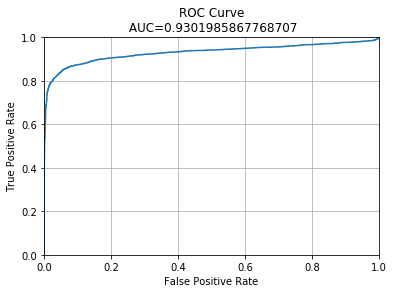

In [ ]:
logreg = LogisticRegression()
model_training(logreg, x_train, y_train)

plot_auc_curve(logreg, x_test, y_test)
Find_Optimal_Cutoff(logreg, x_test, y_test)
print("\n********************************")
print("\nTraining Error")
print_accurcay_metrics(logreg, x_train, y_train, 0.5)
print("\n********************************")
print("Test Error")
print_accurcay_metrics(logreg, x_test, y_test, 0.5)

# GradientBoostingClassifier

In [ ]:
from sklearn.ensemble  import GradientBoostingClassifier
gbt = GradientBoostingClassifier(n_estimators=100, learning_rate= 0.15)
model_training(gbt, x_train, y_train)
print("\n********************************")
print("\nTraining Error")
print_accurcay_metrics(gbt, x_train, y_train, 0.5)
print("\n********************************")
print("Test Error")
print_accurcay_metrics(gbt, x_test, y_test, 0.5)


********************************

Training Error
Accurcay: 0.9760382059800664
AUC: 0.997871588689696
Log Loss: 0.09986656770891165
Confusion Matrix:
 [[12056    43]
 [  534 11447]]
Recall: 0.9554294299307237
Precision: 0.9962576153176675

********************************
Test Error
Accurcay: 0.962003239068145
AUC: 0.9947234221407607
Log Loss: 0.12742901743561597
Confusion Matrix:
 [[3901   37]
 [ 268 3821]]
Recall: 0.9344583027635118
Precision: 0.9904095386210472


In [ ]:
from sklearn.ensemble  import GradientBoostingClassifier
gbt1 = GradientBoostingClassifier(n_estimators=150, learning_rate= 0.15)
model_training(gbt1, x_train, y_train)
print("\n********************************")
print("\nTraining Error")
print_accurcay_metrics(gbt1, x_train, y_train, 0.5)
print("\n********************************")
print("Test Error")
print_accurcay_metrics(gbt1, x_test, y_test, 0.5)


********************************

Training Error
Accurcay: 0.9858388704318937
AUC: 0.999266798570972
Log Loss: 0.06433776499297483
Confusion Matrix:
 [[12072    27]
 [  314 11667]]
Recall: 0.9737918370753693
Precision: 0.9976911236531555

********************************
Test Error
Accurcay: 0.9698517503425937
AUC: 0.9968844244011575
Log Loss: 0.09640387323651516
Confusion Matrix:
 [[3905   33]
 [ 209 3880]]
Recall: 0.9488872584984104
Precision: 0.9915665729619217


# AdaBoostClassifier

Optimal Cutoff: [0.49711388]

********************************

Training Error
Accurcay: 0.9620431893687708
AUC: 0.9899642185616385
Log Loss: 0.5933498226341877
Confusion Matrix:
 [[12000    99]
 [  815 11166]]
Recall: 0.9319756280777899
Precision: 0.9912117177097204
Accurcay: 0.9466799551513642
AUC: 0.9716598348006227
Log Loss: 0.5941402286581511
Confusion Matrix:
 [[3882   56]
 [ 372 3717]]
Recall: 0.909024211298606
Precision: 0.9851576994434137


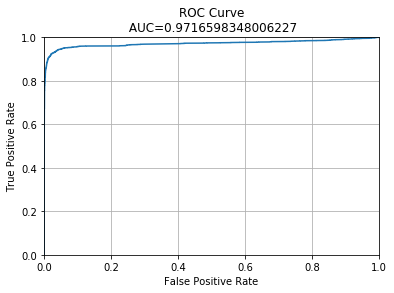

In [ ]:
adaBoost = AdaBoostClassifier(n_estimators=150)
model_training(adaBoost, x_train, y_train)

plot_auc_curve(adaBoost, x_test, y_test)
Find_Optimal_Cutoff(adaBoost, x_test, y_test)
print("\n********************************")
print("\nTraining Error")
print_accurcay_metrics(adaBoost, x_train, y_train, 0.5)
print_accurcay_metrics(adaBoost, x_test, y_test, 0.5)

# Random Forest Classifier

Optimal Cutoff: [0.55166667]


array([0.55166667])

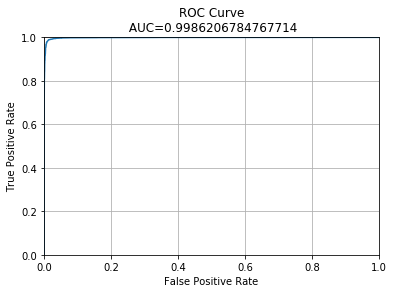

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
rf = RandomForestClassifier(n_estimators=600, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf, x_train, y_train)

 

plot_auc_curve(rf, x_test, y_test)
Find_Optimal_Cutoff(rf, x_test, y_test)

In [ ]:
print("\n********************************")
print("\nTraining Error")
print_accuracy_metrics(rf, x_train, y_train, 0.5)
print("\n********************************")
print("Test Error")
print_accuracy_metrics(rf, x_test, y_test, 0.5)


********************************

Training Error
Accurcay: 1.0
AUC: 1.0
Log Loss: 0.02197102669986089
Confusion Matrix:
 [[12099     0]
 [    0 11981]]
Recall: 1.0
Precision: 1.0

********************************
Test Error
Accurcay: 0.9860470910676467
AUC: 0.9986206784767714
Log Loss: 0.07147149124747355
Confusion Matrix:
 [[3863   75]
 [  37 4052]]
Recall: 0.9909513328442162
Precision: 0.9818269929731039


Optimal Cutoff: [0.556]


array([0.556])

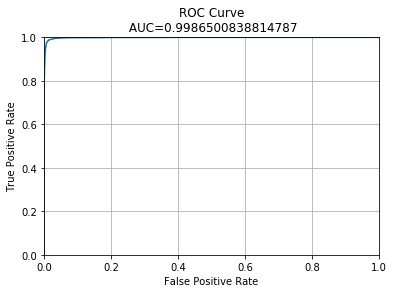

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
rf1 = RandomForestClassifier(n_estimators=500, 
                            criterion='gini', 
                            max_features='sqrt',
                            n_jobs=-1)
model_training(rf1, x_train, y_train)

 

plot_auc_curve(rf1, x_test, y_test)
Find_Optimal_Cutoff(rf1, x_test, y_test)




In [ ]:
print("\n********************************")
print("\nTraining Error")
print_accuracy_metrics(rf1, x_train, y_train, 0.5)

 

print("\n********************************")
print("Test Error")
print_accuracy_metrics(rf1, x_test, y_test, 0.5)


********************************

Training Error
Accurcay: 1.0
AUC: 1.0
Log Loss: 0.021758208959550846
Confusion Matrix:
 [[12099     0]
 [    0 11981]]
Recall: 1.0
Precision: 1.0

********************************
Test Error
Accurcay: 0.9856733524355301
AUC: 0.9986500838814787
Log Loss: 0.0711119528988972
Confusion Matrix:
 [[3864   74]
 [  41 4048]]
Recall: 0.9899730985571045
Precision: 0.9820475497331392


In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import os
import itertools
from glob import glob
import PIL
from PIL import Image
from scipy import ndimage 
import scipy
import sys

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

Using TensorFlow backend.


### Displaying sample training images:

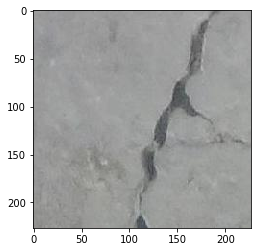

In [ ]:
img_positive = 'concerete_crack_images/training/Positive/1.jpg'
image =  plt.imread(img_positive)
image = np.asarray(image)
plt.imshow(image)

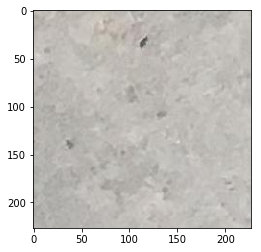

In [ ]:
img_positive = 'concerete_crack_images/training/Negative/1.jpg'
image =  plt.imread(img_positive)
image = np.asarray(image)
plt.imshow(image)

### Preprocessing the training data using standardization

In [ ]:
train_data_dir_positive = "concerete_crack_images/training/Positive/"
train_data_dir_negative = "concerete_crack_images/training/Negative/"

crack_Negative_df = pd.DataFrame(columns=( 'path', 'image', 'label'),index=np.arange(0,16037))
crack_Positive_df = pd.DataFrame(columns=( 'path', 'image', 'label'),index=np.arange(0,16070))

imageid_path_dict_Negative = np.array([x for x in glob(os.path.join(train_data_dir_negative, '*.jpg'))])
imageid_path_dict_Positive = np.array([x for x in glob(os.path.join(train_data_dir_positive, '*.jpg'))])

print(len(imageid_path_dict_Negative))

16037


In [ ]:
crack_Negative_df['path']=imageid_path_dict_Negative
crack_Negative_df['label']=0
crack_Negative_df['image']=crack_Negative_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,100))))

crack_Positive_df['path']=imageid_path_dict_Positive
crack_Positive_df['label']=1
crack_Positive_df['image']=crack_Positive_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,100))))

print("Negative:",crack_Negative_df["image"][0].shape)
print("Positive:",crack_Positive_df["image"][0].shape)

print(imageid_path_dict_Negative.shape,imageid_path_dict_Positive.shape)

crack_df = crack_Negative_df.append(crack_Positive_df)  
crack_df.reset_index(drop=True,inplace=True) 
print(crack_df.shape)

Negative: (100, 75, 3)
Positive: (100, 75, 3)
(16037,) (16070,)
(32107, 3)


In [ ]:
features=crack_df.drop(columns=['label'],axis=1)
target=crack_df["label"]

x_train_o, x_test_o, y_train, y_test = train_test_split(features, target, test_size=0.20,random_state=1)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std

# Reshape image in 3 dimensions (height = 100px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))

### Using Keras sequential model with sigmoid as activation function

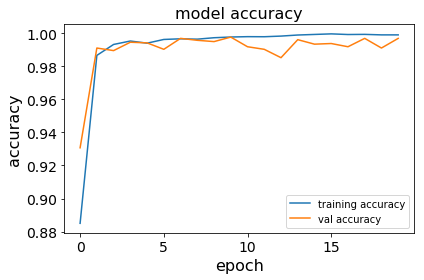

In [ ]:
history = model1_stand.history
fig, ax = plt.subplots()

ax.plot(history.history['accuracy'],label='training accuracy')
ax.plot(history.history['val_accuracy'],label='val accuracy')

ax.set_title('model accuracy',{'size':16})
ax.set_xlabel('epoch',{'size':16})
ax.set_ylabel('accuracy',{'size':16})
              
plt.tick_params(labelsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [ ]:
model1_stand = Sequential()

model1_stand.add(Conv2D(32, (3, 3), input_shape = (75, 100, 3), activation = 'relu',padding = 'same'))
model1_stand.add(MaxPooling2D(pool_size = (2, 2)))
model1_stand.add(Dropout(0.25))


model1_stand.add(Conv2D(64, (3, 3), padding = 'same',activation = 'relu'))
model1_stand.add(MaxPooling2D(pool_size = (2, 2)))
model1_stand.add(Dropout(0.25))


model1_stand.add(Flatten())
model1_stand.add(Dense(units = 128, activation = 'relu'))
model1_stand.add(Dense(units = 1, activation = 'sigmoid'))

model1_stand.summary()
model1_stand.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model1_stand.fit(x_train, y_train, validation_split=0.1,epochs=20, batch_size=256)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 25, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)            

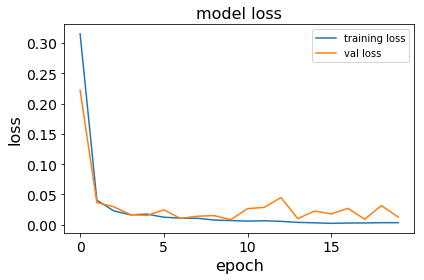

In [ ]:
fig, ax = plt.subplots()

ax.plot(history.history['loss'],label='training loss')
ax.plot(history.history['val_loss'],label='val loss')

ax.set_title('model loss',{'size':16})
ax.set_xlabel('epoch',{'size':16})
ax.set_ylabel('loss',{'size':16})
              
plt.tick_params(labelsize=14)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc = model1_stand.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.9912799596786499


### ImageGenerator

In [ ]:
model_ig = Sequential()

model_ig.add(Conv2D(16, (3, 3), input_shape = (75, 100, 3),padding='same', activation = 'relu'))
model_ig.add(MaxPooling2D(pool_size = (2, 2)))
model_ig.add(Conv2D(32, (3, 3), padding = 'same',activation = 'relu'))
model_ig.add(MaxPooling2D(pool_size = (2, 2)))
model_ig.add(Conv2D(64, (3, 3), padding = 'same',activation = 'relu'))
model_ig.add(MaxPooling2D(pool_size = (2, 2)))
model_ig.add(Flatten())
model_ig.add(Dense(units = 128, activation = 'relu'))
model_ig.add(Dense(units = 1, activation = 'sigmoid'))

model_ig.summary()
model_ig.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

datagen = ImageDataGenerator(validation_split=0.20)

datagen.fit(x_train)

training_generator = datagen.flow(x_train, y_train, batch_size=128)

result = model_ig.fit_generator(training_generator, epochs=20)                            

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 16)       448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 12, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6912)             

In [ ]:
test_loss, test_acc = model_ig.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.9970414042472839


ReLu used as an activation for model2_ig sequential model

In [ ]:
model2_ig = Sequential()

model2_ig.add(Conv2D(16, (3, 3), input_shape = (75, 100, 3),padding='same', activation = 'relu'))
model2_ig.add(MaxPooling2D(pool_size = (2, 2)))
model2_ig.add(Conv2D(32, (3, 3), padding = 'same',activation = 'relu'))
model2_ig.add(MaxPooling2D(pool_size = (2, 2)))
model2_ig.add(Conv2D(64, (3, 3), padding = 'same',activation = 'relu'))
model2_ig.add(MaxPooling2D(pool_size = (2, 2)))
model2_ig.add(Flatten())
model2_ig.add(Dense(units = 128, activation = 'relu'))
model2_ig.add(Dense(units = 1))

model2_ig.summary()
model2_ig.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    
datagen_new = ImageDataGenerator(validation_split=0.20,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5)

datagen_new.fit(x_train)

training_generator_new = datagen_new.flow(x_train, y_train, batch_size=128)

result = model2_ig.fit_generator(training_generator_new, epochs=30)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 16)       448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 12, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6912)             

In [ ]:
test_loss, test_acc = model2_ig.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.49563997983932495


Sigmoid added as activation function in the model2_ig sequential model

In [ ]:
model2_ig = Sequential()

model2_ig.add(Conv2D(16, (3, 3), input_shape = (75, 100, 3),padding='same', activation = 'relu'))
model2_ig.add(MaxPooling2D(pool_size = (2, 2)))
model2_ig.add(Conv2D(32, (3, 3), padding = 'same',activation = 'relu'))
model2_ig.add(MaxPooling2D(pool_size = (2, 2)))
model2_ig.add(Conv2D(64, (3, 3), padding = 'same',activation = 'relu'))
model2_ig.add(MaxPooling2D(pool_size = (2, 2)))
model2_ig.add(Flatten())
model2_ig.add(Dense(units = 128, activation = 'relu'))
model2_ig.add(Dense(units = 1))
model2_ig.add(Dense(units = 1, activation = 'sigmoid'))

model2_ig.summary()
model2_ig.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    
datagen_new = ImageDataGenerator(validation_split=0.20,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5)

datagen_new.fit(x_train)

training_generator_new = datagen_new.flow(x_train, y_train, batch_size=128)

result = model2_ig.fit_generator(training_generator_new, epochs=30)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 75, 100, 16)       448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 50, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 25, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 12, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6912)             

In [ ]:
test_loss, test_acc = model2_ig.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.9922142624855042


### Testing the model

[[4.004571e-06]]
not cracked


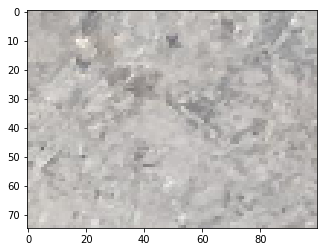

In [ ]:
import glob
import numpy as np
from keras.preprocessing import image
inp = image.load_img("concerete_crack_images/test/242061700105601.png",target_size=(75,100,3))
#inp = img_to_array(inp)
plt.imshow(inp)
img = np.expand_dims(inp, axis=0)
img = (img - x_train_mean)/x_train_std
output = model_ig.predict(img)
print(output)
if output[0] > 0.8:
    print("cracked")
else:
    print('not cracked')

#### Labelling the class for the test set images with predictions based on the ImageGenerator model:

In [ ]:
import glob
import numpy as np
from keras.preprocessing import image
test_data = 'concerete_crack_images/test'
result_array = []
for img in glob.glob('concerete_crack_images/test/*.*'):
  test_image = image.load_img(img, target_size = (75, 100, 3))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  test_image = ((test_image - x_train_mean) / x_train_std)
  result = model_ig.predict(test_image)
  if result[0][0] > 0.8:
    print(img + '===\n\n' + 'crack')
    prediction = 'crack'
    result_array.append(prediction)
  else:
    print(img + '===\n\n' + 'intact')
    prediction = 'nocrack'
    result_array.append(prediction)

Exporting the CSV based on the prediction on the best model (based on accuracy scores)

In [ ]:
val_data_dir = "C:/Users/kumar/Data Science Assignment/Final Project/concerete_crack_images/concerete_crack_images/test/"
val_imgs = os.listdir(val_data_dir)
print(len(val_imgs))
test_df = pd.DataFrame(index=np.arange(0,7893))
test_df['image_id']=val_imgs
test_df['predicted_class']=result_array
test_df.to_csv('Image_generator_sequential_output.csv', index=False)

7893
